# LDA Projection of Data (redo)
[Link to sklearn docs](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#comparison-of-lda-and-pca-2d-projection-of-iris-dataset)

In [41]:
from sklearn.utils import resample

def resample_data(df):
    df_control =df[df.GroupID==0]  #246
    df_park = df[df.GroupID==1] #399
    df_msa = df[df.GroupID==2]  #52
    df_psp = df[df.GroupID==3]  #55

    max_length = max([len(df_park), len(df_msa), len(df_psp), len(df_control)])

    if len(df_control) > 0:
        df_control = resample(df_control, replace=True, n_samples=max_length, random_state=3)
    if len(df_msa) > 0:
        df_msa = resample(df_msa, replace=True, n_samples=max_length, random_state=1)
    if len(df_psp) > 0:
        df_psp = resample(df_psp, replace=True, n_samples=max_length, random_state=2)

    return pd.concat([df_control, df_park, df_msa, df_psp])

In [40]:
from sklearn import svm
from sklearn.metrics import classification_report

def svm_grid_search(X_train, X_test, y_train, y_test, cv=5):

    tuned_parameters = [{'kernel': ['linear'], 'C': [1]}]

    print("# Tuning hyper-parameters for f1")
    print()

    clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=cv,
                       scoring='f1_macro',
                       n_jobs = -1 )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    
    return clf

In [3]:
# Read in the data
import pandas as pd

raw_data = pd.read_excel('data/training_data.xlsx')

# remove unneeded subject ID column
data = raw_data.drop('Subject', axis=1)

In [ ]:
# split the X and y data
X = data_resampled.values[:,:-1]
y = data_resampled.values[:,-1]


(746, 38)
(1596, 38)
explained variance ratio (LDA): [0.58840312 0.31923686 0.09236002]


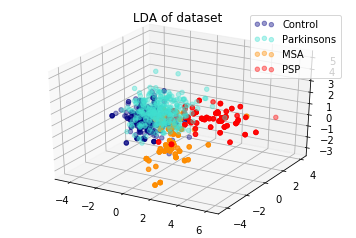

In [42]:
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

data_resampled = resample_data(data)

print(data.shape)
print(data_resampled.shape)


target_names = ['Control', 'Parkinsons', 'MSA', 'PSP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=44)


#standardize the data
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)


lda = LinearDiscriminantAnalysis(n_components=3)
X_train_lda = lda.fit(X_train_std, y_train).transform(X_train_std)
X_test_lda = lda.fit(X_train_std, y_train).transform(X_test_std)

print('explained variance ratio (LDA): %s'
      % str(lda.explained_variance_ratio_))


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for color, i, target_name in zip(colors, [0, 1, 2, 3], target_names):
    ax.scatter(X_train_lda[y_train == i, 0], X_train_lda[y_train == i, 1], X_train_lda[y_train == i, 2], alpha=.4, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title('LDA of dataset')

plt.show()

In [43]:
clf = svm_grid_search(X_train_lda, X_test_lda, y_train, y_test, cv=5)

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

0.835 (+/-0.032) for {'C': 1, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.88      0.91      0.90        80
        1.0       0.77      0.80      0.79        92
        2.0       0.85      0.85      0.85        71
        3.0       0.89      0.81      0.84        77

avg / total       0.84      0.84      0.84       320




In [44]:
model = clf.best_estimator_

validation_data = pd.read_excel('./data/Validation.xlsx')
validation_data = validation_data.drop('GUID', axis=1)
validation_data = validation_data.drop('Subject', axis=1)
validation_data = validation_data[data.columns]

validation_data

X_valid = validation_data.values[:,:-1]
y_valid = validation_data.values[:,-1]

X_valid_std = std_scale.transform(X_valid)
X_valid_lda = lda.transform(X_valid_std)

model.score(X_valid_lda, y_valid)


0.74

### Plot the validation data on the LDA plot

<IPython.core.display.Javascript object>


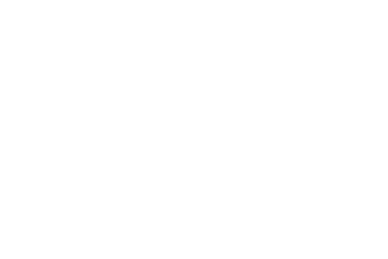

<IPython.core.display.Javascript object>


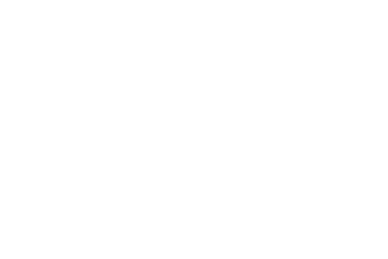

In [45]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['lightgreen', 'turquoise', 'yellow', 'pink']
for color, i, target_name in zip(colors, [0, 1, 2, 3], target_names):
    ax.scatter(X_train_lda[y_train == i, 0], X_train_lda[y_train == i, 1], X_train_lda[y_train == i, 2], alpha=1, color=color,
                label=target_name, marker='^', s=10)
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title('LDA of dataset')

# plot Validation data
new_colors = ['darkgreen', 'navy', 'darkorange', 'red']
for color, i, target_name in zip(new_colors, [0, 1, 2, 3], target_names):
    ax.scatter(X_valid_lda[y_valid == i, 0], X_valid_lda[y_valid == i, 1], X_valid_lda[y_valid == i, 2], alpha=1, color=color,
                label=target_name, marker='o', s=20)



plt.show()

In [46]:
means_train = data.groupby('GroupID').mean()
means_valid = validation_data.groupby('GroupID').mean()

In [47]:
means_train

,Age,Sex,UPDRS,aSN_FA,Caudate_FA,CC2_FA,GP_FA,LobuleVI_FA,LobuleV_FA,MCP_FA,...,pSN_FW,Putamen_FW,SCP_FW,STN_FW,Thalamus_FW,Vermis_FW,RN_FW,PPN_FW,Dentate_FW,CC1_FW
GroupID,,,,,,,,,,,,,,,,,,,,,
0,63.366667,0.508333,3.299583,0.658426,0.214429,0.737095,0.322795,0.239803,0.244544,0.636795,...,0.180413,0.172144,0.356283,0.115177,0.146802,0.185291,0.101717,0.120458,0.179685,0.295724
1,64.238095,0.298246,30.086466,0.662097,0.220929,0.747541,0.335253,0.242854,0.248429,0.641929,...,0.195634,0.173250,0.342426,0.115427,0.142557,0.181386,0.102993,0.119083,0.177476,0.281892
2,66.615385,0.442308,48.607692,0.650274,0.210970,0.733988,0.337108,0.234036,0.247070,0.606783,...,0.214691,0.258022,0.450237,0.124866,0.170775,0.220001,0.130292,0.124918,0.258338,0.288187
3,71.000000,0.345455,40.007273,0.677361,0.189328,0.711547,0.333134,0.236017,0.236119,0.633809,...,0.288166,0.225824,0.523387,0.162933,0.200316,0.209242,0.183980,0.158763,0.257027,0.346361


In [48]:
means_valid

,Age,Sex,UPDRS,aSN_FA,Caudate_FA,CC2_FA,GP_FA,LobuleVI_FA,LobuleV_FA,MCP_FA,...,pSN_FW,Putamen_FW,SCP_FW,STN_FW,Thalamus_FW,Vermis_FW,RN_FW,PPN_FW,Dentate_FW,CC1_FW
GroupID,,,,,,,,,,,,,,,,,,,,,
0,70.50000,0.833333,4.666667,0.646025,0.210057,0.757729,0.267373,0.194953,0.210287,0.602295,...,0.153475,0.140633,0.405257,0.106429,0.157977,0.156623,0.092857,0.110609,0.152952,0.278413
1,64.65625,0.375000,33.375000,0.637834,0.213922,0.743883,0.274059,0.204833,0.211652,0.607521,...,0.155094,0.118085,0.370541,0.096439,0.142413,0.156721,0.092188,0.091013,0.143529,0.319089
2,65.00000,0.250000,77.250000,0.633123,0.199634,0.704999,0.303082,0.205272,0.207698,0.599120,...,0.163118,0.172743,0.477533,0.098133,0.151898,0.210019,0.105418,0.106276,0.232961,0.372804
3,72.37500,0.625000,57.125000,0.639363,0.219810,0.744538,0.272502,0.196259,0.190131,0.624993,...,0.216328,0.125427,0.562548,0.159022,0.182290,0.166998,0.173218,0.159255,0.190739,0.430600


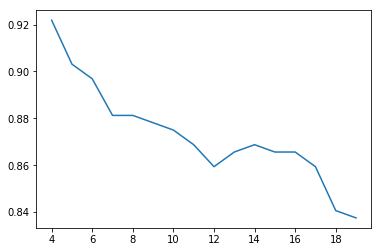

In [67]:
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier

ns = range(4,20)
scores_knn = []

for n in ns:
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(X_train_lda, y_train)
    scores_knn.append(neigh.score(X_test_lda, y_test))
    
plt.plot(ns, scores_knn)
plt.show()

In [68]:
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train_lda, y_train)
neigh.score(X_test_lda, y_test)

0.921875

In [69]:
neigh.score(X_valid_lda, y_valid)

0.7

In [70]:
y_valid

array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3.])

In [71]:
neigh.predict(X_valid_lda)

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 1., 1., 2., 1., 1., 1., 1., 1., 1., 3., 3., 3., 3., 1.])